Archivos: _diamonds_train.csv, diamonds_test.csv_

El objetivo es estimar el precio (​ price ) ​ de un diamante a partir de un conjunto de
propiedades físicas del mismo:

* carat: peso del diamante
* cut: calidad del corte: Fair, Good, Very good, Premium, Ideal.
* color: desde color J (peor color) a D (mejor color)
* clarity: medida de la claridad del diamante (I1 (peor calidad), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (mejor claridad))
* x: longitud en mm
* y: anchura en mm.
* z: profundidad en mm
* depth: porcentaje de profundidad total 2 * z / (x + y)
* table: ancho de la punta del diamante relativa al punto más ancho.

### Realizamos los imports necesarios y creamos las funciones necesarias

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso

from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [26]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [27]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

### Análisis exploratorio

In [28]:
# cargamos el fichero de datos y mostramos las primeras filas para tomar una primera impresión de los datos
data = pd.read_csv('./data/diamonds_train.csv')#'data/diamonds_train.csv')
data.head(10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.43,Very Good,E,SI2,59.9,57.0,671,4.88,4.94,2.94
1,1.15,Good,H,SI1,60.2,61.0,5005,6.74,6.84,4.09
2,0.52,Ideal,E,VS2,61.3,56.0,1621,5.17,5.21,3.18
3,0.32,Ideal,G,VVS2,61.7,57.0,730,4.41,4.44,2.73
4,1.00,Premium,D,SI1,61.4,58.0,5880,6.43,6.37,3.93
5,0.29,Very Good,G,VVS2,60.2,59.0,541,4.27,4.30,2.58
6,1.01,Ideal,G,SI1,62.3,56.0,5006,6.42,6.38,3.99
7,0.60,Ideal,E,VS1,62.2,56.0,2306,5.36,5.44,3.36
8,0.38,Ideal,D,SI2,62.0,53.0,599,4.68,4.71,2.91
9,1.59,Very Good,J,VS1,60.7,59.0,8515,7.49,7.54,4.56


Vemos que cut, color y clarity son variables categóricas. Las variables numéricas parecen continuas. Un análisis mas detallado lo confirmará.

In [29]:
data.shape

(43152, 10)

vemos que tenemos 9 variables (+ la objetivo) y mas de 43.000 muestras

In [30]:
data['price'].value_counts()

544      106
802      104
605      103
625      103
776      102
828      101
789       98
698       91
666       91
552       86
720       85
596       84
1013      83
675       81
645       80
526       79
765       79
684       77
844       76
854       72
561       71
743       69
658       69
945       68
579       67
505       67
984       66
863       66
827       63
911       62
        ... 
2472       1
17522      1
9310       1
10668      1
12406      1
5304       1
6259       1
13372      1
4555       1
14801      1
8276       1
10732      1
10636      1
7289       1
8626       1
16769      1
10389      1
8557       1
12720      1
17554      1
16737      1
8525       1
406        1
5272       1
6474       1
7321       1
14638      1
15517      1
9374       1
16206      1
Name: price, Length: 10722, dtype: int64

La variable objetivo es de tipo continuo

In [31]:
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

confirmamos que tenemos varias variables de texto y tenemos que explorar sus valores para comprobar si con categóricas

In [32]:
data.isnull().any()

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x          False
y          False
z          False
dtype: bool

por suerte no tenemos valores nulos

In [33]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,43152.0,0.799810,0.474396,0.2,0.40,0.70,1.04,5.01
depth,43152.0,61.752361,1.439128,43.0,61.00,61.80,62.50,79.00
table,43152.0,57.462706,2.229668,43.0,56.00,57.00,59.00,76.00
price,43152.0,3942.483384,3990.866274,326.0,954.00,2421.00,5335.00,18823.00
x,43152.0,5.735674,1.121841,0.0,4.72,5.70,6.54,10.74
y,43152.0,5.739552,1.149528,0.0,4.73,5.71,6.54,58.90
z,43152.0,3.541920,0.708278,0.0,2.91,3.53,4.04,31.80


Las variables carat, y , z y price tengo que comprobar mas adelante si tenemos outliers

Las variables x,y y z tienen valores mínimos a 0. Siendo las dimensiones del diamante no debería haber valores a 0. Tengo que hacer limpieza de las filas que tengan alguna de estas variables a 0

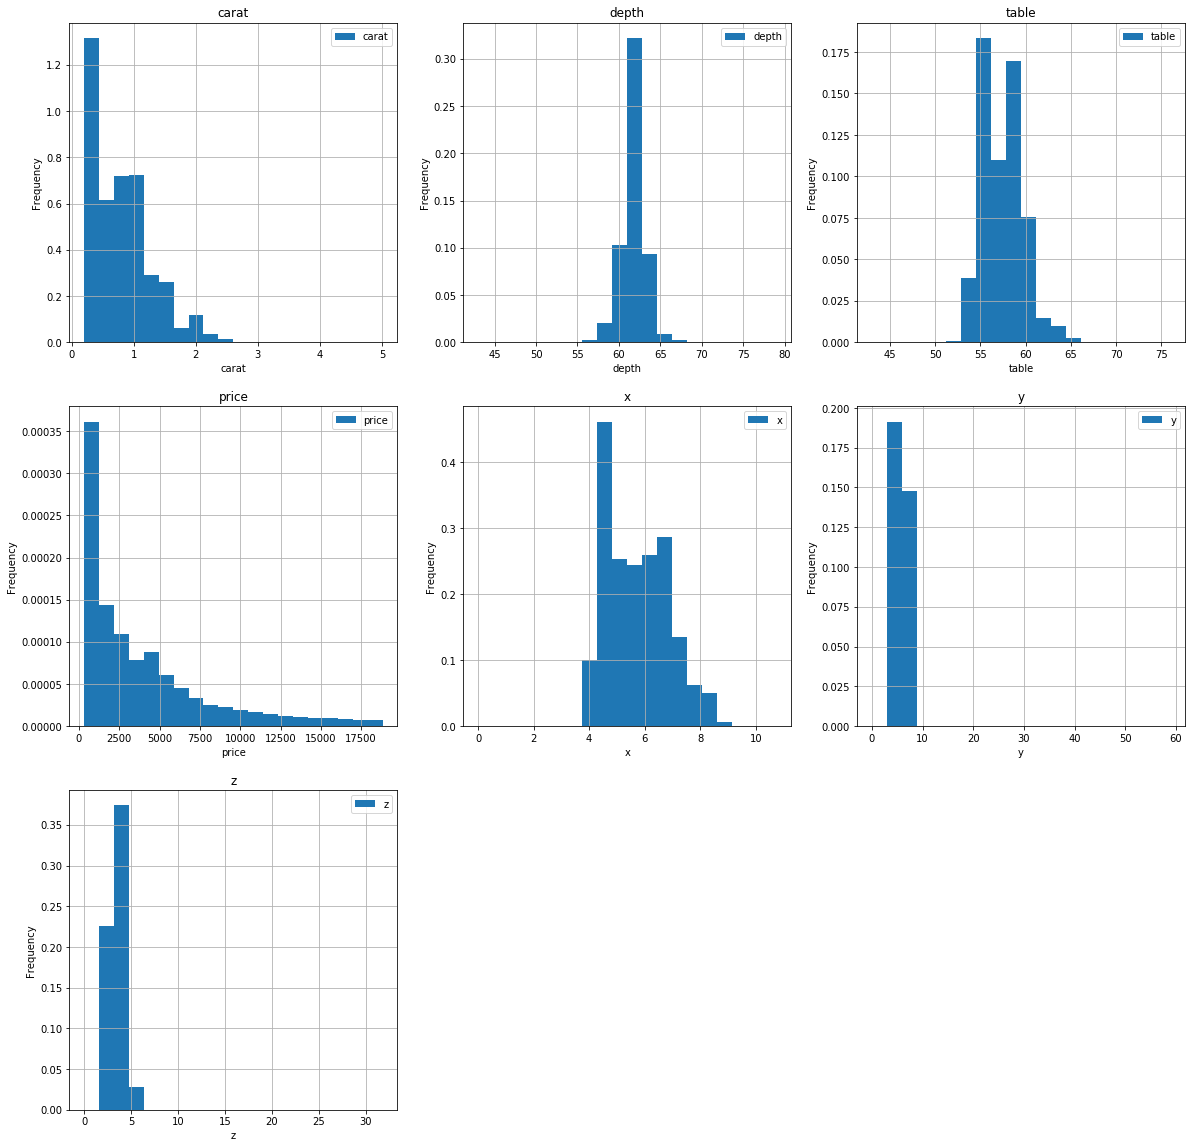

In [34]:
plt.figure(figsize = (20, 20))


for i, feature in enumerate(data.select_dtypes(include = [np.number]).columns):
    plt.subplot(3, 3, i + 1)
    
    data[feature].plot.hist(bins=20, density=1, grid = True)
    plt.xlabel(feature)
    plt.legend()
    plt.title(feature)

plt.show()

# Mirar en los videos lo de la distribución cuando se hace logaritmo para justificarlo
La distribución de algunas variables no es normal

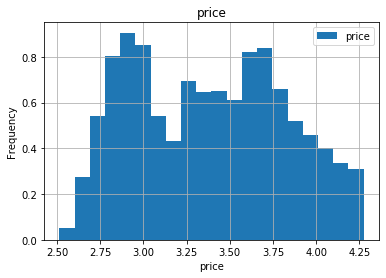

In [35]:
data['price'] = data['price'].apply(lambda x: np.log10(x))

data['price'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('price')
plt.legend()
plt.title('price')

plt.show()

### Feature Engineering


In [36]:
cols = data.columns[data.dtypes == 'object']
cols

Index(['cut', 'color', 'clarity'], dtype='object')

Vamos a estudiar los valores de las variables categóricas

In [37]:
for col in cols:
    print(data[col].value_counts())

Ideal        17109
Premium      11059
Very Good     9714
Good          3983
Fair          1287
Name: cut, dtype: int64
G    9006
E    7777
F    7591
H    6694
D    5457
I    4360
J    2267
Name: color, dtype: int64
SI1     10512
VS2      9874
SI2      7353
VS1      6489
VVS2     4048
VVS1     2856
IF       1428
I1        592
Name: clarity, dtype: int64


En un primer momento he codificado las variables categóricas con LabelEncoder. Posteriormente, repasando el dataset he decido dar los valores según se explica en el dataset que da más valor al precio del diamante.

Con este cambio he conseguido mejorar algo la predicción de los modelos

In [38]:
'''
le = LabelEncoder()

cols_bin = ['cut', 'color', 'clarity']

for col in cols_bin:
    data[col] = le.fit_transform(data[col])
'''

data['cut']     = data['cut'].map({"Fair": 0, "Good": 1, "Very Good": 2,  "Premium": 3, "Ideal": 4})
data['color']   = data['color'].map({"J": 0, "I": 1, "H": 2, "G": 3, "F": 4, "E": 5, "D": 6})
data['clarity'] = data['clarity'].map({"I1": 0, "SI2": 1, "SI1": 2, "VS2": 3, "VS1": 4, "VVS2": 5, "VVS1": 6, "IF": 7})

data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.43,2,5,1,59.9,57.0,2.826723,4.88,4.94,2.94
1,1.15,1,2,2,60.2,61.0,3.699404,6.74,6.84,4.09
2,0.52,4,5,3,61.3,56.0,3.209783,5.17,5.21,3.18
3,0.32,4,3,5,61.7,57.0,2.863323,4.41,4.44,2.73
4,1.00,3,6,2,61.4,58.0,3.769377,6.43,6.37,3.93


Limpiamos las muestras donde x, y o z tengan como valor 0

In [39]:
data.drop(data[(data['x'] == 0) | (data['y'] == 0) | (data['z'] == 0)].index, inplace = True)

### Correlación entre variables

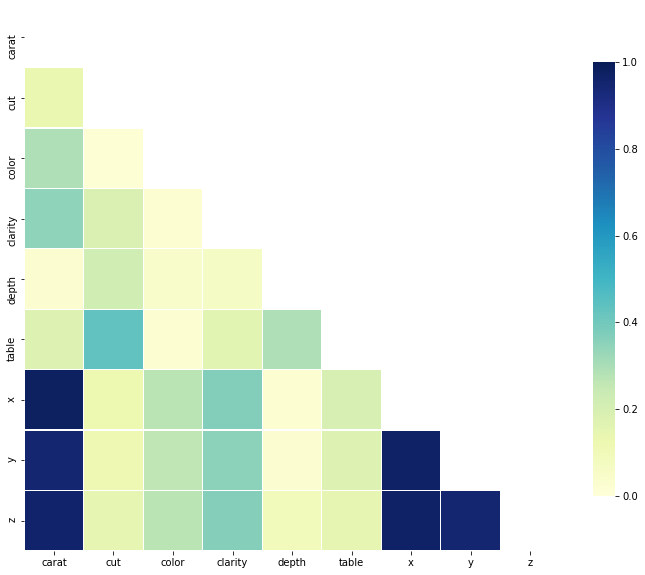

In [40]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Se ve una alta correlacción de carat con x, y y z, pero también de x, y y z entre si. Estoy dudando entre eliminar estas tres variables o multiplicarlas para hacer una iteración.

In [41]:
#data['volume'] = data['x'] * data['y'] * data['z']
data = data.drop(['x', 'y', 'z'], axis = 1)

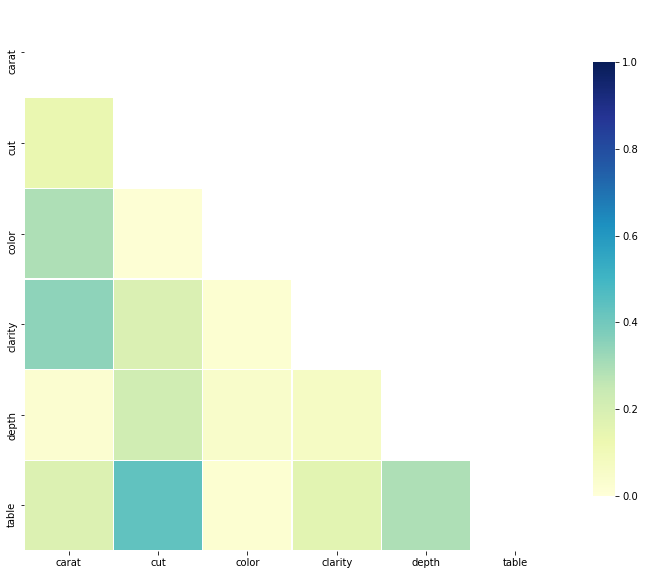

In [42]:
# Compute the correlation matrix
corr = np.abs(data.drop(['price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

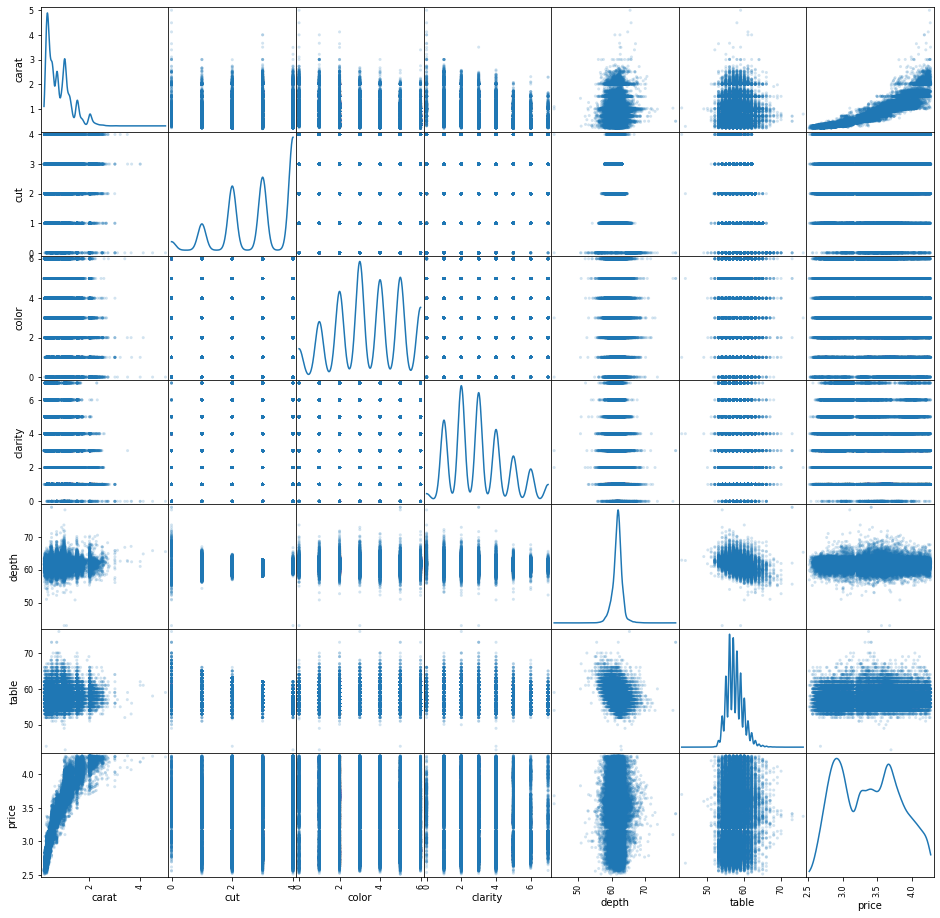

In [43]:
pd.plotting.scatter_matrix(data, alpha = 0.2, figsize = (16, 16), diagonal = 'kde')
plt.show()

Vemos que entre carat y price y entre columen y price hay una relación exponencial. Opto por ver hacer una transformación logaritmica de las tres variables para que tengan una relación lineal

In [44]:
for v in ['price','carat']:
    data[v] = np.log(data[v])

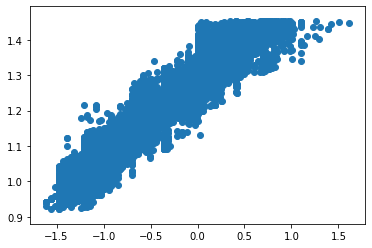

In [45]:
plt.scatter(data['carat'], data['price'])
plt.show()


### División de variables.


In [46]:
# preparamos los datos
features = data.columns.drop(['price'])
X = data[features].values
y = data['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle= True, random_state = 42)

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))

Datos train:  (32352, 6)
Datos test:   (10784, 6)
Propocion train:1.211
Propocion test: 1.208


In [47]:
X_train

array([[-1.02165125e+00,  4.00000000e+00,  5.00000000e+00,
         2.00000000e+00,  6.14000000e+01,  5.70000000e+01],
       [-4.30782916e-01,  2.00000000e+00,  2.00000000e+00,
         6.00000000e+00,  6.16000000e+01,  5.80000000e+01],
       [ 4.31782416e-01,  3.00000000e+00,  1.00000000e+00,
         4.00000000e+00,  6.16000000e+01,  5.80000000e+01],
       ...,
       [-5.62118918e-01,  2.00000000e+00,  5.00000000e+00,
         1.00000000e+00,  5.97000000e+01,  5.70000000e+01],
       [-5.79818495e-01,  4.00000000e+00,  6.00000000e+00,
         1.00000000e+00,  6.22000000e+01,  5.50000000e+01],
       [ 9.95033085e-03,  1.00000000e+00,  5.00000000e+00,
         2.00000000e+00,  6.32000000e+01,  5.90000000e+01]])

### Búsqueda del modelo óptimo

Voy a probar distintos modelos de clasificación, empezando por los más sencillos y terminando con los más complejos.


#### Regresión lineal

In [48]:
lr = LinearRegression()
lr.fit(Xs_train, y_train)

y_pred_train = lr.predict(Xs_train)
y_pred_test = lr.predict(Xs_test)

mseTrainModelLR = mean_squared_error(y_train, y_pred_train)
mseTestModelLR = mean_squared_error(y_test, y_pred_test)

print('MSE Modelo Lineal Simple (train): %0.7g' % mseTrainModelLR)
print('MSE Modelo Lineal Simple (test) : %0.7g' % mseTestModelLR)
print("R^2 (train): {:.4f}".format(lr.score(Xs_train, y_train)))
print("R^2 (test): {:.4f}".format(lr.score(Xs_test, y_test)))

print('Coefficients:')
w = lr.coef_
for f, wi in zip(features, w):
    print(f, wi)



MSE Modelo Lineal Simple (train): 0.0003851577
MSE Modelo Lineal Simple (test) : 0.0003846437
R^2 (train): 0.9776
R^2 (test): 0.9774
Coefficients:
carat 0.14187597712177302
cut 0.004330130259398765
color 0.018142102906723356
clarity 0.025738881889602945
depth -0.0007260334215329684
table -4.339326766783693e-05


### Ridge

best mean cross-validation score: -0.000
best parameters: {'alpha': 1000.0}


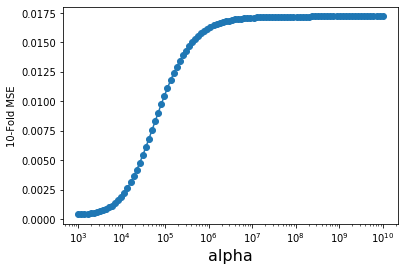

In [49]:
#alpha_vector = np.logspace(-25,1,100)
#alpha_vector = np.logspace(-3,1,100)
#alpha_vector = np.logspace(-1,5,100)
#alpha_vector = np.logspace(3,7,100)
alpha_vector = np.logspace(3,10,100)

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10, n_jobs=8)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((0, 1))
plt.show()

In [50]:
alpha_optimo = grid.best_params_['alpha']
ridge = Ridge(alpha = alpha_optimo).fit(Xs_train, y_train)

y_pred_train = ridge.predict(Xs_train)
y_pred_test = ridge.predict(Xs_test)

mseTrainModelRidge = mean_squared_error(y_train, y_pred_train)
mseTestModelRidge = mean_squared_error(y_test, y_pred_test)

print('MSE Modelo Ridge (train): %0.3g' % mseTrainModelRidge)
print('MSE Modelo Ridge (test) : %0.3g' % mseTestModelRidge)
print("R^2 (train): {:.4f}".format(ridge.score(Xs_train, y_train)))
print("R^2 (test): {:.4f}".format(ridge.score(Xs_test, y_test)))

w = ridge.coef_
for f, wi in zip(features, w):
    print(f, wi)

MSE Modelo Ridge (train): 0.000414
MSE Modelo Ridge (test) : 0.000412
R^2 (train): 0.9759
R^2 (test): 0.9757
carat 0.13585653305118142
cut 0.004131767721278987
color 0.01599404608542825
clarity 0.02280234870196712
depth -0.0007165829243447823
table 0.00045644518322157266


De manera sorprendente optenemos uns resultado muy similares a la regresión lineal

#### Lasso

best mean cross-validation score: -0.000
best parameters: {'alpha': 4.094915062380427e-05}


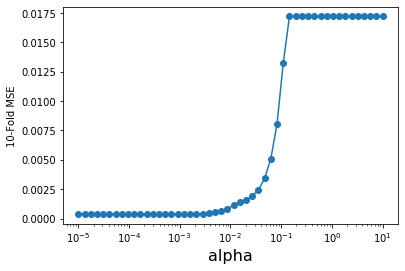

In [51]:
# primera iteración
#alpha_vector = np.logspace(-1,10,50)
#alpha_vector = np.logspace(-1,2,50)
alpha_vector = np.logspace(-5,1,50)
#alpha_vector = np.logspace(-7,0,50)


param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10, n_jobs=8)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

In [52]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(Xs_train,y_train)

ytrainLasso = lasso.predict(Xs_train)
ytestLasso  = lasso.predict(Xs_test)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print("R^2 (train): {:.4f}".format(lasso.score(Xs_train, y_train)))
print("R^2 (test): {:.4f}".format(lasso.score(Xs_test, y_test)))

w = lasso.coef_
for f,wi in zip(features,w):
    print(f,wi)

MSE Modelo Lasso (train): 0.000385
MSE Modelo Lasso (test) : 0.000385
R^2 (train): 0.9776
R^2 (test): 0.9774
carat 0.14178709817830543
cut 0.0043174235234922234
color 0.018079768031329067
clarity 0.025675161368131923
depth -0.0006798176627086685
table -0.0


Sigo con el mismo resultado que en la regresión lineal

#### DecisionTree

best mean cross-validation score: -0.000
best parameters: {'max_depth': 11.333333333333332}


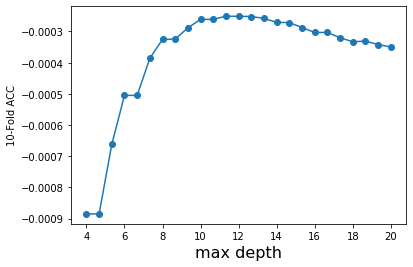

In [53]:
max_depth = np.linspace(1,15,25)
max_depth = np.linspace(4,20,25)
param_grid = {'max_depth': max_depth}

grid = GridSearchCV(DecisionTreeRegressor(), 
                    scoring = 'neg_mean_squared_error', 
                    param_grid = param_grid, 
                    cv = 10,
                    n_jobs=8)

grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(max_depth,scores,'-o')
plt.xlabel('max depth', fontsize=16)
plt.ylabel('10-Fold ACC')
plt.show()

In [54]:
#max_depth_opt = grid.best_params_['max_depth']
#max_depth_opt = grid.best_params_['max_depth'] - 1 
#max_depth_opt = grid.best_params_['max_depth'] + 1 
max_depth_opt = grid.best_params_['max_depth'] - 2
dtr = DecisionTreeRegressor(random_state = 0, max_depth = max_depth_opt).fit(Xs_train,y_train)

ytrainDTR = dtr.predict(Xs_train)
ytestDTR  = dtr.predict(Xs_test)
mseTrainModelDTR = mean_squared_error(y_train,ytrainDTR)
mseTestModelDTR = mean_squared_error(y_test,ytestDTR)

print('MSE Modelo DecisionTreeRegressor (train): %0.3g' % mseTrainModelDTR)
print('MSE Modelo DecisionTreeRegressor (test) : %0.3g' % mseTestModelDTR)

print("R^2 (train): {:.4f}".format(dtr.score(Xs_train, y_train)))
print("R^2 (test): {:.4f}".format(dtr.score(Xs_test, y_test)))


MSE Modelo DecisionTreeRegressor (train): 0.000248
MSE Modelo DecisionTreeRegressor (test) : 0.000277
R^2 (train): 0.9856
R^2 (test): 0.9837


Si ajusto un poco el maxdepth obtengo en test unos resultados muy similares a los de train. Con el maxdepth de 12 no estaban muy lejanos, pero así parece que está más ajustado

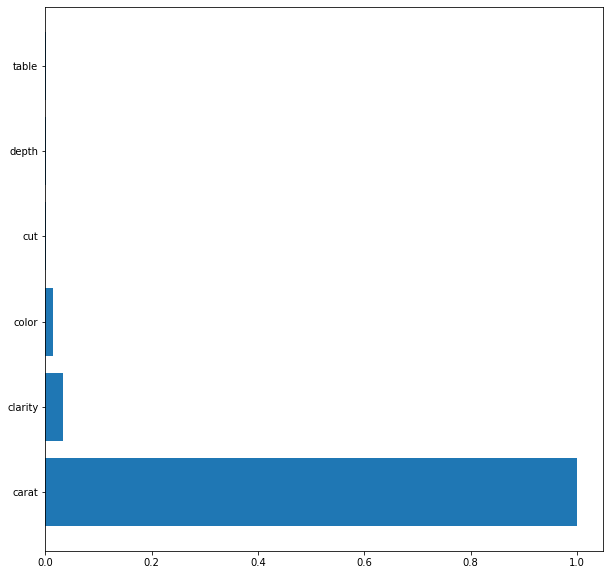

In [55]:
importances = dtr.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

Carat sigue siendo la variable que más afecta al precio

#### Random Forest

best mean cross-validation score: 0.987
best parameters: {'max_depth': 17}


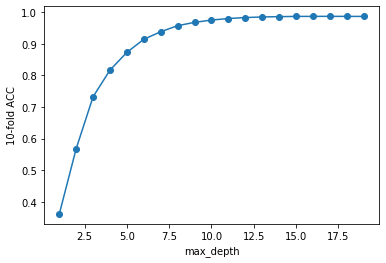

In [56]:
#maxDepth = range(1,15)
maxDepth = range(1,20)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, 
                                           n_estimators=200, 
                                           max_features='sqrt'), 
                                           param_grid=tuned_parameters,
                                           cv=10,
                                           n_jobs=8)
grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [57]:
# max_depth_opt = grid.best_params_['max_depth']
# max_depth_opt = grid.best_params_['max_depth'] - 1
# max_depth_opt = grid.best_params_['max_depth'] - 2
# max_depth_opt = grid.best_params_['max_depth'] - 3
# max_depth_opt = grid.best_params_['max_depth'] - 4
# max_depth_opt = grid.best_params_['max_depth'] - 5
# max_depth_opt = grid.best_params_['max_depth'] - 6
max_depth_opt = grid.best_params_['max_depth'] - 7
rfr = RandomForestRegressor(random_state = 0, max_depth = max_depth_opt).fit(Xs_train,y_train)

ytrainFRF = rfr.predict(Xs_train)
ytestFRF  = rfr.predict(Xs_test)
mseTrainModelFRF = mean_squared_error(y_train,ytrainFRF)
mseTestModelFRF = mean_squared_error(y_test,ytestFRF)

print('MSE Modelo RandomForestRegressor (train): %0.3g' % mseTrainModelFRF)
print('MSE Modelo RandomForestRegressor (test) : %0.3g' % mseTestModelFRF)

print("R^2 (train): {:.4f}".format(rfr.score(Xs_train, y_train)))
print("R^2 (test): {:.4f}".format(rfr.score(Xs_test, y_test)))

MSE Modelo RandomForestRegressor (train): 0.00018
MSE Modelo RandomForestRegressor (test) : 0.000211
R^2 (train): 0.9895
R^2 (test): 0.9876


Al igual que en el modelo anterior con el max_depth obtenido en la validación cruzada estabamos obteniendo un modelo un poco sobre entrenado. Bajando el max_depth a 10 obtenemos resultados muy similares en train y test

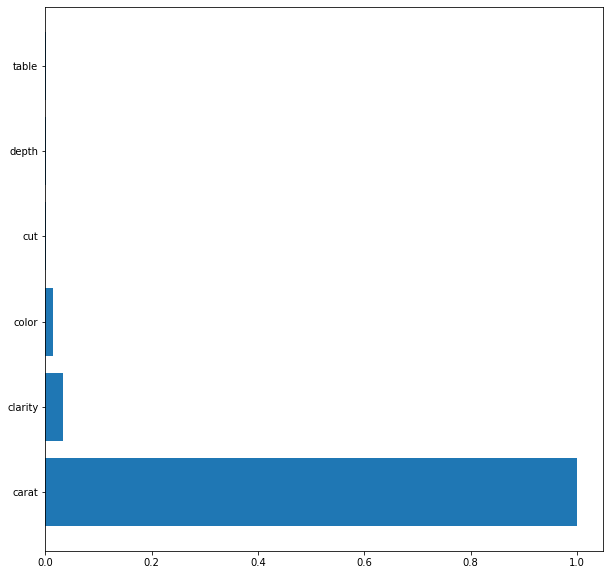

In [58]:
importances = rfr.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

#### Gradient Boosting

In [59]:
Niterations = [500,1000,1500,2000]
learningRate = [0.1,0.05]
maxDepth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=maxDepth), param_grid=param_grid, cv = 10, n_jobs=8)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.990
best parameters: {'learning_rate': 0.1, 'n_estimators': 2000}


In [60]:
learning_rate_opt = grid.best_params_['learning_rate']
n_estimators_opt = grid.best_params_['n_estimators']

bt = GradientBoostingRegressor(random_state=0, max_depth=maxDepth,learning_rate= learning_rate_opt, n_estimators= n_estimators_opt).fit(Xs_train,y_train)

ytrainBT = bt.predict(Xs_train)
ytestBT  = bt.predict(Xs_test)
mseTrainModelBT = mean_squared_error(y_train,ytrainBT)
mseTestModelBT = mean_squared_error(y_test,ytestBT)

print('MSE Modelo RandomForestRegressor (train): %0.3g' % mseTrainModelBT)
print('MSE Modelo RandomForestRegressor (test) : %0.3g' % mseTestModelBT)

print("R^2 (train): {:.4f}".format(bt.score(Xs_train, y_train)))
print("R^2 (test): {:.4f}".format(bt.score(Xs_test, y_test)))

MSE Modelo RandomForestRegressor (train): 0.000148
MSE Modelo RandomForestRegressor (test) : 0.000166
R^2 (train): 0.9914
R^2 (test): 0.9902


He hecho pruebas con varios valores de max_depth. Con valor 3 parece que da los valores mas ajustados entre los datos de train y test. 

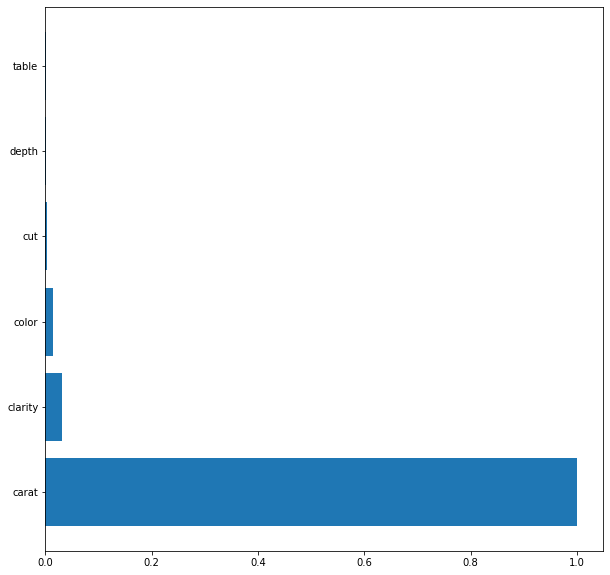

In [61]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

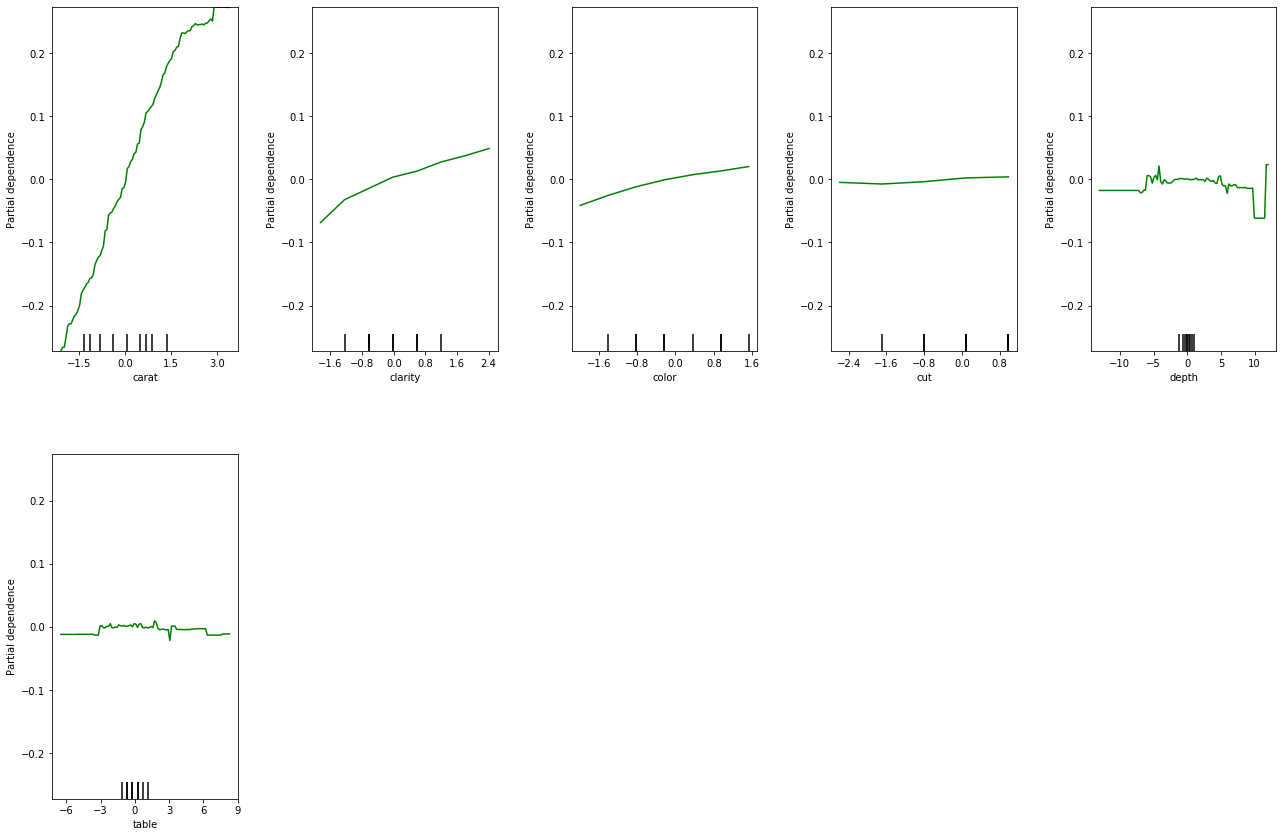

In [62]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

fig, ax = plot_partial_dependence(bt, Xs_train, indices, feature_names=features,
                                 percentiles=(0.0, 1.0), n_cols = 5)
fig.set_size_inches(20, 20)
plt.show()

Como venimos viendo carat es la variable demás peso para predecir el precio. Le sigue depth, y en menor medida clarity, table, color y corte. 

El modelo con el que me voy a quedar es el **GradientBoostingRegressor** que nos está dando un resultados del 99% de acierto con el conjunto de test que he creado.

### Aplicación del modelo

In [65]:
data = pd.read_csv('./data/diamonds_test.csv')#'data/diamonds_train.csv')
data.head(10)

# codificacion de variables categoricas
data['cut']     = data['cut'].map({"Fair": 0, "Good": 1, "Very Good": 2,  "Premium": 3, "Ideal": 4})
data['color']   = data['color'].map({"J": 0, "I": 1, "H": 2, "G": 3, "F": 4, "E": 5, "D": 6})
data['clarity'] = data['clarity'].map({"I1": 0, "SI2": 1, "SI1": 2, "VS2": 3, "VS1": 4, "VVS2": 5, "VVS1": 6, "IF": 7})

data = data.drop(['x', 'y', 'z'], axis = 1)

data['carat'] = np.log(data['carat'])

data.head(10)

,id,carat,cut,color,clarity,depth,table
0,0,-0.597837,2,5,1,59.6,57.0
1,1,-1.049822,4,3,2,60.6,56.0
2,2,0.425268,1,2,7,63.1,57.0
3,3,-0.653926,4,5,4,61.8,56.0
4,4,-0.616186,4,6,2,62.6,55.0
5,5,0.336472,2,3,5,63.4,59.0
6,6,0.412110,3,4,4,62.7,59.0
7,7,0.463734,4,0,4,61.3,57.0
8,8,-0.061875,2,2,1,62.7,61.0
9,9,-1.171183,3,5,3,62.7,58.0


In [66]:
features = data.columns.drop(['id'])

X = data[features].values
Xs = scaler.transform(X)

y_pred_ = bt.predict(Xs)
data['target'] = y_pred_
data_save = data[['id', 'target']]
data_save.head(10)

,id,target
0,0,1.132175
1,1,1.024177
2,2,1.408575
3,3,1.193018
4,4,1.163797
5,5,1.405485
6,6,1.431562
7,7,1.375451
8,8,1.265664
9,9,1.062411


In [67]:
data_save.to_csv('./data/diamonds_results.csv')